<a href="https://colab.research.google.com/github/jboca-andes/MIAD_ML_and_NLP/blob/main/Semana%205/S5TC1_Analisis_Sentimientos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [53]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [54]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [55]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [56]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

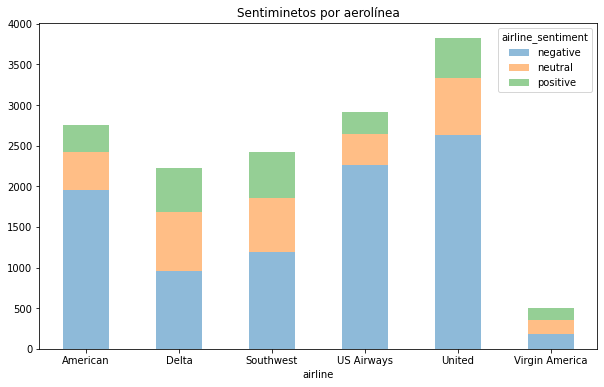

In [57]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [58]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [59]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [60]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [61]:
#Funciones
import matplotlib.pyplot as plt
def etiquetas(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

def graficar(resultados):
  escenarios = list(resultados.keys())
  valores = list(resultados.values())
  plt.rcParams["figure.figsize"] = (5*len(resultados),5)
  plt.bar(range(len(resultados)), valores, tick_label=escenarios)
  etiquetas(range(len(resultados)), valores)
  plt.show()

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

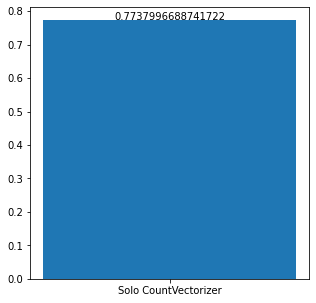

CPU times: user 10.4 s, sys: 16.9 ms, total: 10.4 s
Wall time: 10.8 s


In [62]:
# Celda 1
%%time
resultados = {}
vec = CountVectorizer()
rfc = RandomForestClassifier()
X_train_vec = vec.fit_transform(X_train)
rfc.fit(X_train_vec, y_train)
test = rfc.predict(vec.transform(X_test))
accuracy_score(y_test, test)
resultados["Solo CountVectorizer"] = accuracy_score(y_test, test)
graficar(resultados)

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

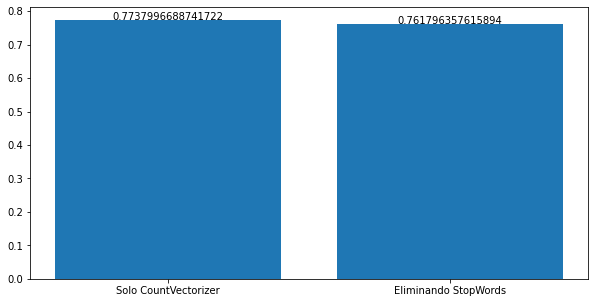

CPU times: user 10.3 s, sys: 25.4 ms, total: 10.3 s
Wall time: 10.3 s


In [63]:
# Celda 2
%%time
vec = CountVectorizer(stop_words="english")
rfc = RandomForestClassifier()
X_train_vec = vec.fit_transform(X_train)
rfc.fit(X_train_vec, y_train)
test = rfc.predict(vec.transform(X_test))
accuracy_score(y_test, test)
resultados["Eliminando StopWords"] = accuracy_score(y_test, test)
graficar(resultados)

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

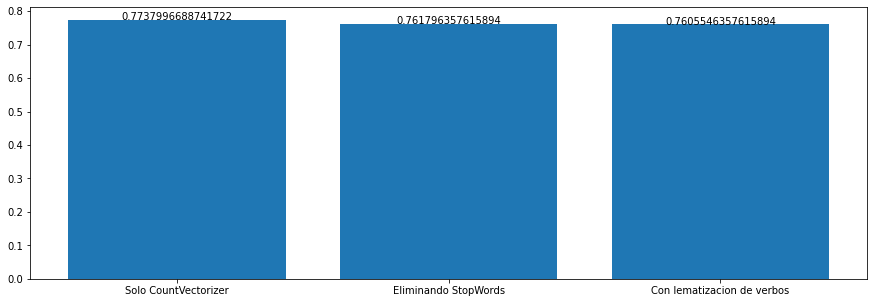

CPU times: user 13.2 s, sys: 29.8 ms, total: 13.3 s
Wall time: 13.2 s


In [64]:
# Celda 3
%%time
class lematizador(object):
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, palabras):
    return [self.wnl.lemmatize(p, 'v') for p in palabras.split(' ')]

vec = CountVectorizer(tokenizer=lematizador())
rfc = RandomForestClassifier()
X_train_vec = vec.fit_transform(X_train)
rfc.fit(X_train_vec, y_train)
test = rfc.predict(vec.transform(X_test))
accuracy_score(y_test, test)
resultados["Con lematizacion de verbos"] = accuracy_score(y_test, test)
graficar(resultados)

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


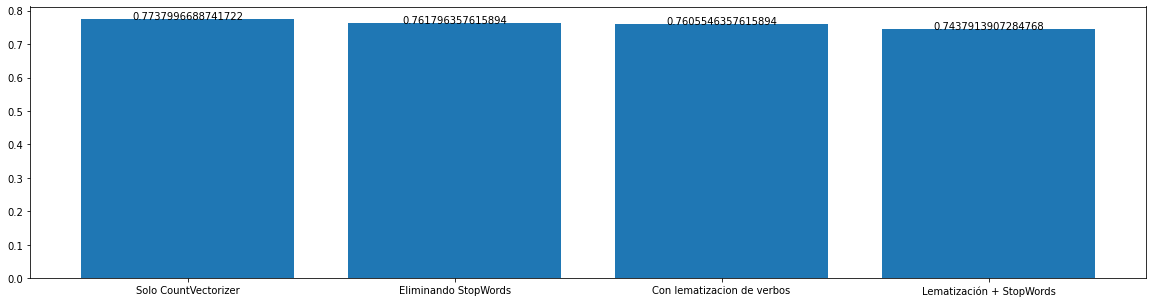

In [65]:
# Celda 4
%time
vec = CountVectorizer(tokenizer=lematizador(), stop_words="english")
rfc = RandomForestClassifier()
X_train_vec = vec.fit_transform(X_train)
rfc.fit(X_train_vec, y_train)
test = rfc.predict(vec.transform(X_test))
accuracy_score(y_test, test)
resultados["Lematización + StopWords"] = accuracy_score(y_test, test)
graficar(resultados)

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

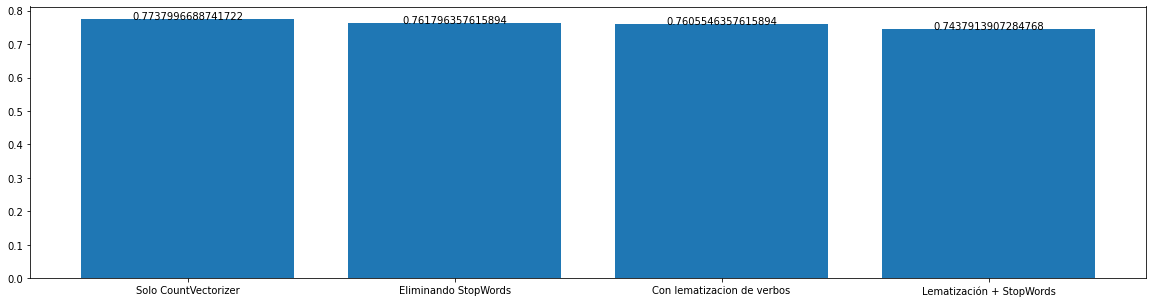

In [66]:
# Celda 5
graficar(resultados)

#Considerando los diferentes escenarios, se puede evidenciar que el comportamiento de el Punto 1 es mejor al comportamiento de los demás escenarios, esto se puede deber a diversos factores como:
  #1. La cantidad de informacion disponible en un tweet es de solo 140 caracteres y desde hace muy poco tiempo se dispuso la opción de llegar a 280 caracteres.
  #2. Es posible que lo que se considera una Stopword, esté aportando a la información recolectada

#Ventajas y desventajas:
 #1. El modelo de mejor desempeño tambien tiene un menor consumo de procesador.
 #2. El modelo de menor desempeño está realizando tareas adicionales que implican una mayor carga de maquina y un menor comportamiento del modelo.

#Cabe anotar que estas ventajas y desventajas no pueden extrapolarse a todos los escenarios.

